# Example notebook: Processing sea ice draft 

Obtaining time series of sea ice draft from a Signature500 dataset (procedure is the same for Signature 250).

- Assumes that instrument data in `.ad2cp` format has been converted to `.mat` files using Nortek's [SignatureDEployment](https://www.nortekgroup.com/assets/software/SignatureDeployment.4.7.2.StandAlone.x64.zip) software (free).
    - To test this notebook on your system, you can download some [test files from Zenodo](https://zenodo.org/records/13223574) (put the files in `test_data/`).
- Assumes that the instrument has profiled in "ice draft" mode, i.e. that it has fields like `Average_AltimeterDistanceLE`. 


>**Note**
>
>We load the Signature dataset as an *xarray Dataset*, `ds`. To inspect the dataset (view the structure and content of the dataset and its metadata), simply execute `ds` in a cell. 

#### Imports

In [6]:
import kobbe
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

## Load the Signature data

The function `kobbe.load.matfiles_to_dataset()` will look for `.mat` files in the specified directory, parse these files and concatenate them into one single xarray Dataset. 

A few more things happen in this step:

- The dataset is **reshaped** from a single `time_average` dimension to two dimensions:
    - `TIME`: Time stamp of the ensemble averaged measurement
    - `SAMPLE`: Sample number within the ensemble

- Instrument **tilt** is calculated from pitch and roll components.

- **Ice presence** is calculated based on the FOM criterion of the slanted beams. We also calculate a "sea ice concentration" per ensebmle based on ice presence. This creates some new variables:
    - `ICE_IN_SAMPLE(TIME, SAMPLE)`: (Boolean) True if ice is detected in ALL founr beams.
    - `ICE_IN_SAMPLE_ANY(TIME, SAMPLE)`: (Boolean) True if ice is detected in ANY of the four beams.
    - `SIC_FOM(TIME)`: (percent) "Sea ice concentration" in each ensemble calculated as the fraction of samples per ensemble where `ICE_IN_SAMPLE` is True.
    - `SIC_FOM_ALT(TIME)`: (percent) "Sea ice concentration" in each ensemble calculated as the fraction of samples per ensemble where `ICE_IN_SAMPLE_ANY` is True.

Load the data. Note that we specify (fake) lat/lon. Optional, but will be needed for various computations eventually. 

In [7]:
import kobbe

In [8]:
ddir = 'test_data/' # The directory of the source .mat file data
ds = kobbe.load.matfiles_to_dataset(ddir, lat=80, lon = 30, )

266496 time points, 5552 ensembles. Samples per ensemble: 48
Done. Run kobbe.load.overview()) to print some additional details.


Useful at this stage to print an overview of the data we have loaded (and check that it matches expectations!)

In [9]:
kobbe.load.overview(ds)


TIME RANGE:
18 May 2019 12:15  -->  15 Jul 2019 08:00  (57.8 days)
Time between ensembles: 15.0 min.
Time between samples in ensembles: 1.0 sec.

PRESSURE:
Median (STD) of altimeter pressure (Average_AltimeterPressure): 20.6 dbar (0.3 dbar) - with fixed atm offset 9.500 dbar.

SIZE:
Total 266496 time points.
Split into 5552 ensembles with 48 sample(s) per ensemble.
Ocean velocity bins: 16.


## Load and append some auxilary data

It is possible to obtain an ice draft estimate from just Signature data. However, the ice draft estimates if we have data from an adjacent CTD sensor (to make corrections for accurate sound speed an density) and atmospheric pressure (to more accurately determine instrument depth based on the pressure the overlying seawater). Magnetic declination is important in the post-processing of ice and ocean velocities. 

Add to the dataset:
- CTD data (if we have a CTD sensor mounted along with the Signature)
- Atmospheric pressure (from ERA5)
- Magnetic declination (from the World Magnetic Model)

#### CTD data

Appending CTD data if we have it. Calculating TEOS-10 variables (Absolute Salinity, Conservative Temperature), sound speed, and density using the [gsw](https://teos-10.github.io/GSW-Python/) module.


Below, we append some mock data. Appending real data from a file could look like this: 

```
from kval.file import matfile
ds_ctd = matfile.mat_to_xr_1D('ctd_data.mat')
ds = append.append_ctd(ds, ds_ctd.T, ds_ctd.S, ds_ctd.P, ds_ctd.TIME, )
```


##### *Create some mock CTD data*

In [10]:
mock_time = np.arange(ds.TIME[0], ds.TIME[-1])
L_mock = len(mock_time)
mock_temp = np.random.rand(L_mock)*5 -1.8  # Temperature
mock_sal = np.random.rand(L_mock)*1.5 + 33.5  # Salinity
mock_pres = np.random.rand(L_mock) + 20  # Pressure

/tmp/ipykernel_863472/2908580992.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  mock_time = np.arange(ds.TIME[0], ds.TIME[-1])


##### *Add to the dataset using the `append_ctd()` function*


In [11]:
ds = kobbe.append.append_ctd(ds, mock_temp, mock_sal, mock_pres, mock_time,
         instr_SN = '11111',
       instr_desc = 'SBE37 CTD sensor mounted right below the Signature (for example)' )

This operation adds the variables `'SA_CTD', 'CT_CTD','pres_CTD','sound_speed_CTD', 'rho_CTD'` to the datasets. (Good idea to execute `ds` to verify that these were indeed added).

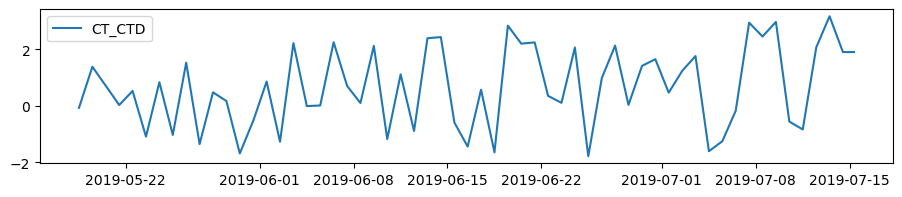

In [12]:
fig, ax = plt.subplots(figsize = (11, 2))
ax.plot(xr.decode_cf(ds).TIME, ds.CT_CTD, '-', label = 'CT_CTD')

leg = ax.legend(); 

#### Atmospheric pressure

If you have a record os atmospheric (sea level) pressure, we can append it to the dataset using `ds = kobbe.append.append_atm_pres()`. 

We can also opt to automatically grab sea level pressure from ERA-5 (nearest grid point to the specified `lat`/`lon`). Hourly ERA-5 data are collected from the [Asia-Pacific Data-Reasearch Center] (http://apdrc.soest.hawaii.edu) over OpenDAP. 

**Note** These operations can take some time (minutes, typically) as we need to access data on the server and cut out a slice of data from a very large dataset.

Auto append ERA5 pressure to the dataset wih `append_atm_pres_auto`

In [13]:
ds = kobbe.append.append_atm_pres_auto(ds)

Loading ERA5 file from APDRC servers (http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/ERA5/hourly/Surface_pressure) .. done.
Evaluating local ERA5 time series .. done.


This operation should append the variable `p_atmo` to the dataset. We can make a quick plot of the variable:

Text(0, 0.5, 'p_atmo [dbar]')

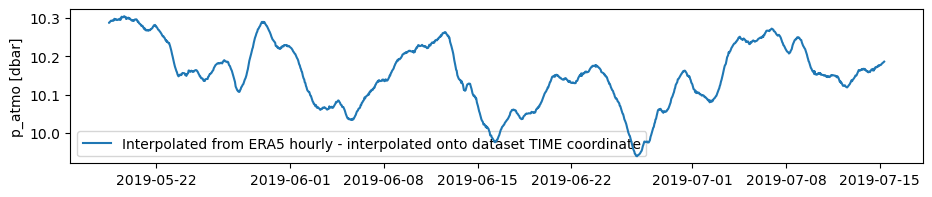

In [14]:
fig, ax = plt.subplots(figsize = (11, 2))
ax.plot(xr.decode_cf(ds).TIME, ds.p_atmo, '-', 
        label = 'Interpolated from ERA5 hourly - interpolated onto dataset TIME coordinate')
leg = ax.legend()
leg.set_zorder(0)
ax.set_ylabel(f'p_atmo [{ds.p_atmo.units}]')

*Note*: We use `xr.decode_cf(ds)` just to get the x-axis to display dates (`2019-05-18`, etc) rather than the Python numerical epoch (`18034`, etc). 

#### Append magnetic declination

Like with pressure, we can specify a known magnetic declination using a designated function, `kobbe.append.append_magdec()`. We also have an automatic alternative, `kobbe.append.append_magdec_auto()`, which will grab magnetic declination from the World Magnetic Model at the coordinate specified by `lat` and `lon` using [pygeomag](https://pypi.org/project/pygeomag/), which is on turn Python API for the [British Geological Survey magnetic field
calculator](https://github.com/filips123/MagneticFieldCalculator/).

##### Obtain and append magnetic declination

In [15]:
ds = kobbe.append.append_magdec_auto(ds)

This adds the variable `magde`. Check it with a quick plot: 

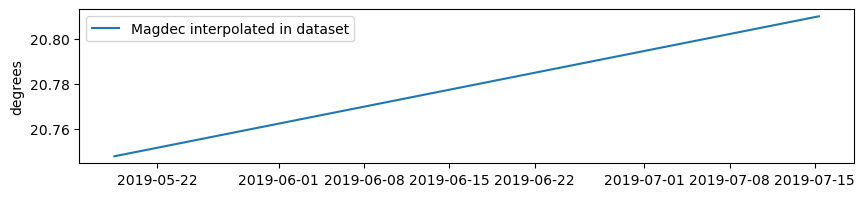

In [16]:
fig, ax = plt.subplots(figsize = (10, 2))
ax.plot(xr.decode_cf(ds).TIME, ds.magdec, '-', 
        label = 'Magdec interpolated in dataset')
ax.legend(); ax.set_ylabel('degrees');

## Calculate sea ice draft

Having set the dataset up, we are now ready to calculate derived variables (such as sea ice draft).

It may be a good idea to save a copy of the dataset at this stage (e.g. `kobbe.load.to_nc(ds, 'MySigDataset_initial.nc')`) in case you want to rerun your post-processing later without having to go through all the initial steps..

### Calculate transducer depth from pressure

Transducer depth is a key variable in computing sea ice draft. `kobbe.calc.dep_from_p()` calculates depth based on the instrument pressure at transducer level (`AveragePressure` minus atmospheric pressure) using the hydrostatic relation. In-situ density is used if available. Gravitational acceleration $g$ is calculated based on latitude using the [gsw](https://teos-10.github.io/GSW-Python/) module.

(If we do not have in-situ density (no `rho_CTD` field in the dataset), the user is prompter whether they want to use a default value of  1027.0 kg m-3 or specify another ficed value.)



In [17]:
ds = kobbe.calc.dep_from_p(ds)

We should now have a variable `depth`.  We can quickly check that it looks reasonable 
- Note that in this case, we provided mock, random CTD data, which will instrocuce some noise.
- If we have deck values (measurements on the surface before deployment or after recovery), a good sanity check at this point is to check that `depth` is reasonably close to 0 at the surface!!

AttributeError: 'Dataset' object has no attribute 'depth'

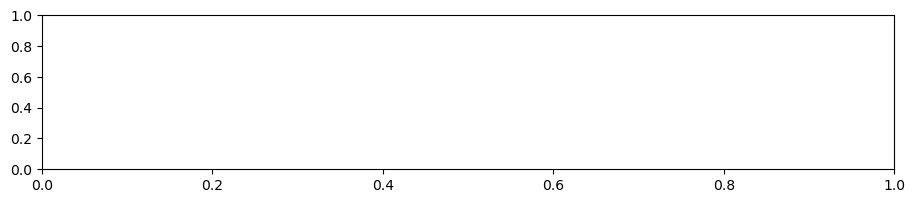

In [18]:
fig, ax = plt.subplots(figsize = (11, 2))
ax.plot(xr.decode_cf(ds).TIME, ds.depth.mean(dim = 'SAMPLE'), '-', )
ax.invert_yaxis(); ax.set_ylabel(f'depth [{ds.depth.units}]')

### Initial sea ice draft calculation

We now calculate an initial estimate of sea ice draft. From this, we will calculate some empirical correction factors that we will apply to the *final* sea ice draft estimate.  

The `kobbe.icedraft.calculate_draft()` function calculates the displacement of the scattering signal below the sea surface, $\eta$, as:

> $\eta =$ `depth` $-$ `Average_AltimeterDistance`$
\cdot \cos ($ `tilt_Average` )$\ \cdot$ `sound_speed_CTD`/`Average_Soundspeed`


- $\eta$ is stored as the variable `SURFACE_DEPTH_(LE, AST)`, where `LE` or `AST` denotes the method used to calculate the signal return time (we mainly use `LE` - leading edge -  for sea ice draft).

- Surface depth estimates where a certain threshold of the manufacturer quality criterion is not met (e.g. `Average_AltimeterQualityAST>8000`) are discarded (set to NaN).
    * The quality threshold (default 8000) can be set using the `qual_thr` parameter in `kobbe.icedraft.calculate_draft()`.
- We also reject (set to NaN) LE measurements where LE and AST length estimates diverged by >0.5 m, reducing valid LE measurements by 29.3% from 266289 to 188385.
    * The AST-LE difference threshold (default 0.5 m) can be set using the `LE_AST_max_sep` parameter in `kobbe.icedraft.calculate_draft()`.

**Sea ice draft** is taken as $\eta$ when ice is present, NaN otherwise.

- Sea ice draft is added as the fields `SEA_ICE_DRAFT_(LE, AST)`.

- Sea ice draft values below -0.5 are rejected (set to NaN)

    * The sea ice draft minimum value (default -0.5 m) can be set using the `minimum_draft` parameter in `kobbe.icedraft.calculate_draft()`.
 
- The median sea ice draft per ensemble is calculated and added as the variables `SEA_ICE_DRAFT_MEDIAN_(LE, AST)`.


In [ ]:
ds = kobbe.icedraft.calculate_draft(ds) # Initial draft estimate

In [ ]:
# Obtain open water correction
ds = kobbe.icedraft.get_open_water_correction(ds, run_window_days=1, fixed_offset=True)

In [ ]:
ds = kobbe.icedraft.calculate_draft(ds) # Recalculate with open-water correction

### Obtain open water correction

Based on the preliminary calculation, we now want to find empirical coefficients $\alpha_{OW}, \beta_{OW}$ such that **in open water** there is minimal offset between the instrument depth and the vertical length measured by the altimeter (after adjusting for tilt and sound speed).

See #8 of the [Processing pipeline documentation](https://kobbe.readthedocs.io/en/latest/pipeline/pipeline.html) for a more thorough explanation. Essentially, we:

- Create an estimate of the low-passed (default-daily) $\eta$ in open water ($\eta_{O, LP}$). 
- Set $\alpha_{OW}$ (a fixed offset applied to depth) to the deployment average value of $\eta_{O, LP}$.
- Set $\beta_{OW}$ (a time-varying correction factor applied to sound speed) such that $\eta_{O, LP}-\alpha_{OW}$ when $\eta_{O, LP}$ is recalculated with $\beta_{OW}$ applied to sound speed.

In [ ]:
ds = kobbe.icedraft.get_open_water_correction(ds, run_window_days=1, fixed_offset=True)

This operation adds the coefficients $\alpha, \beta$ as variables `alpha_(LE, AST)`, `beta_(LE, AST)`.

It also adds some additional fields (`ow_surface_before_correction_..`) that are useful for inspection.

Note that *we have not recalculated sea ice draft at this point!* First, we will inspect the suggested correction using the `kobbe.icedraft.compare_open_water_correction()` function. This will show us an overview of the calculated coefficients, and some statistics of the effects of applying these corrections (if we elect to do so). It also displays various plots, these can be turned off by setting `show_plots=False`.

In [ ]:
kobbe.icedraft.compare_open_water_correction(ds,)

#### Recompute with open water correction

If we are happy with how the open water correction looks, we can apply the corrections by running `icedraft.calculate_draft()` again:

In [16]:
ds = kobbe.icedraft.calculate_draft(ds)

If we inspect the metadata of (e.g.) the `SEA_ICE_DRAFT_MEDIAN_LE`, it should now reflect that open water corrections have been applied:

In [17]:
ds.SEA_ICE_DRAFT_LE

<xarray.DataArray 'SEA_ICE_DRAFT_LE' (TIME: 5552, SAMPLE: 48)> Size: 2MB
array([[0.98333977, 0.96119316, 0.96161267, ..., 0.96993407, 0.9859326 ,
        0.98427727],
       [1.82837873, 1.82145277, 1.82833479, ..., 1.90013623, 1.89873521,
        1.90608165],
       [1.23291454, 1.21121758, 1.20605595, ..., 1.14398412, 1.14929966,
        1.14769121],
       ...,
       [1.58600608, 1.56377972, 1.5632618 , ..., 2.17592246, 2.18646035,
        2.16496808],
       [       nan,        nan, 0.66918199, ..., 0.79328207,        nan,
               nan],
       [       nan, 3.2200648 ,        nan, ...,        nan, 2.71690345,
               nan]])
Coordinates:
  * TIME     (TIME) float64 44kB 1.803e+04 1.803e+04 ... 1.809e+04 1.809e+04
  * SAMPLE   (SAMPLE) int64 384B 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48
Attributes:
    long_name:  Sea ice draft at each sample (LE)
    units:      m
    note:       From LE altimeter distances.\n\nComputed with the function ko...

We can plot a histogram with some statistics to see what out estimate of sea ice draft looks like: 

KeyError: "No variable named 'SEA_ICE_DRAFT_LE'. Variables on the dataset include ['BINS', 'xyz', 'beams', 'TIME', 'SAMPLE', ..., 'ICE_IN_SAMPLE', 'ICE_IN_SAMPLE_ANY', 'SIC_FOM', 'SIC_FOM_ALT', 'INSTRUMENT']"

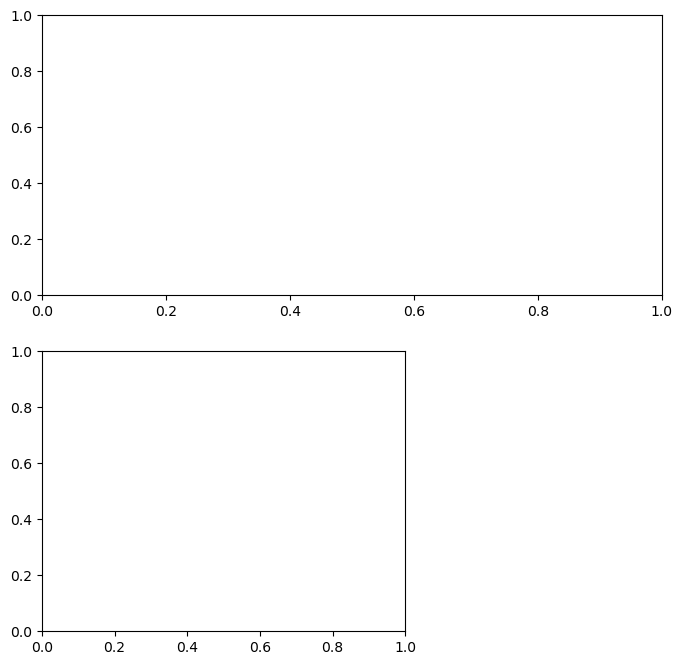

In [5]:
kobbe.toolbox.histogram(ds, 'SEA_ICE_DRAFT_LE')

## Save 

We can save the dataset to netcdf. We can choose to keep all >100 variables, or export a reduced dataset. The default is to just store sea ice draft medians.


In [19]:
kobbe.load.to_nc(ds, 'test_data/test_sig500_icedraft.nc')

Saved data to file:
test_data/test_sig500_icedraft.nc
